# Fit bivariate Matern to empirical (cross-) semivariograms

In [1]:
import sys

sys.path.insert(0, "../../source")


In [2]:
import pickle
import xarray as xr

import fields
import model
import plot


In [3]:
# maximum distance between pairs of points used in variograms
MAX_DIST = 1000
# number of bins in variograms
N_BINS = 30
# optimization bounds for model parameters
PARAM_BOUNDS = dict(
    rho=(1e-8, 1.0),
    nu=[(0.3, 0.95), (0.5, 1.5), (0.3, 0.95)],
    len_scale=(10, 300),
)

# data selection
YEAR = 2021
MONTH = 4
# XCO2 months ahead of SIF
OFFSET = 1

year_month_str = f"{YEAR}0{MONTH}" if MONTH < 10 else f"{YEAR}{MONTH}"


In [4]:
month_xco2 = MONTH + OFFSET
date_sif = f"{YEAR}-{MONTH}-01"
date_xco2 = f"{YEAR}-{month_xco2}-01"

with xr.open_dataset(
    "../../data/intermediate/OCO2_005deg_months2021_north_america_with_basis.nc4"
) as ds:
    basis_vars = [x for x in list(ds.keys()) if x.startswith("B")]
    ds_sif = (
        ds[["sif", "sif_var"] + basis_vars]
        .sel(time=f"{YEAR}-{MONTH}")
        .squeeze()
        .drop_vars(["B1", "B10", "B20"])
    )
    ds_xco2 = ds[["xco2", "xco2_var"] + basis_vars].sel(time=f"{YEAR}-{month_xco2}").squeeze()


In [5]:
ds_sif


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1200)
Coordinates:
  * lat      (lat) float64 22.02 22.07 22.12 22.17 ... 57.82 57.87 57.92 57.97
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.12 -65.07 -65.02
    time     datetime64[ns] 2021-04-01
Data variables: (12/59)
    sif      (lat, lon) float32 ...
    sif_var  (lat, lon) float32 ...
    B2       (lat, lon) float64 ...
    B3       (lat, lon) float64 ...
    B4       (lat, lon) float64 ...
    B5       (lat, lon) float64 ...
    ...       ...
    B55      (lat, lon) float64 ...
    B56      (lat, lon) float64 ...
    B57      (lat, lon) float64 ...
    B58      (lat, lon) float64 ...
    B59      (lat, lon) float64 ...
    B60      (lat, lon) float64 ...

In [6]:
ds_xco2


<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1200)
Coordinates:
  * lat       (lat) float64 22.02 22.07 22.12 22.17 ... 57.82 57.87 57.92 57.97
  * lon       (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.12 -65.07 -65.02
    time      datetime64[ns] 2021-05-01
Data variables: (12/62)
    xco2      (lat, lon) float32 ...
    xco2_var  (lat, lon) float32 ...
    B1        (lat, lon) float64 ...
    B2        (lat, lon) float64 ...
    B3        (lat, lon) float64 ...
    B4        (lat, lon) float64 ...
    ...        ...
    B55       (lat, lon) float64 ...
    B56       (lat, lon) float64 ...
    B57       (lat, lon) float64 ...
    B58       (lat, lon) float64 ...
    B59       (lat, lon) float64 ...
    B60       (lat, lon) float64 ...

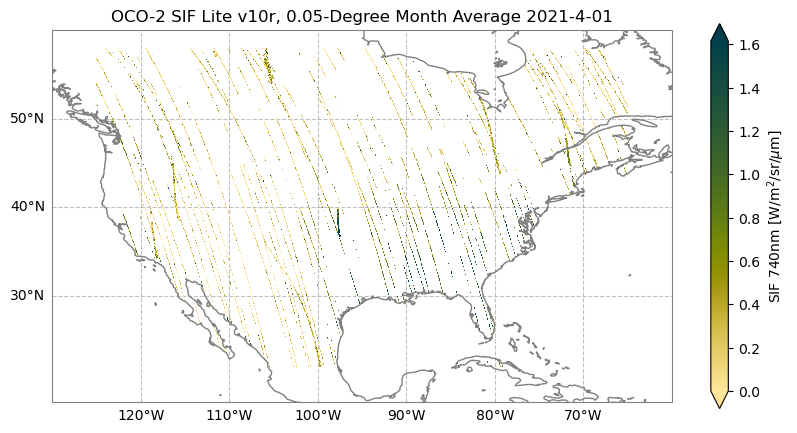

In [7]:
title = f"OCO-2 SIF Lite v10r, 0.05-Degree Month Average {date_sif}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_sif["sif"], vmin=0, robust=True, title=title, label=units)


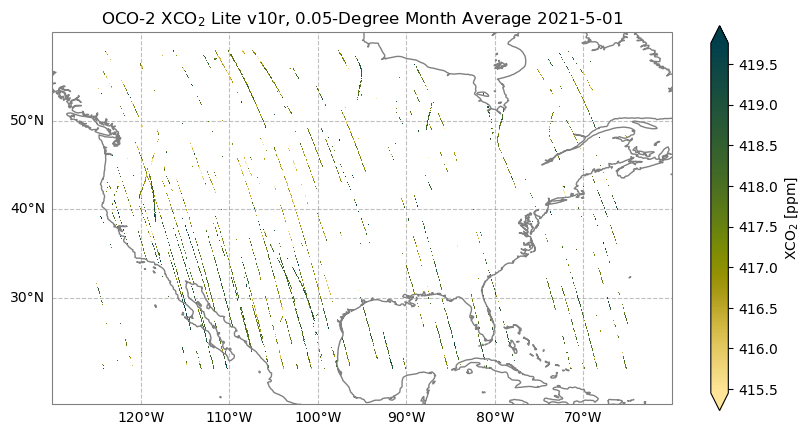

In [8]:
title = f"OCO-2 XCO$_2$ Lite v10r, 0.05-Degree Month Average {date_xco2}"
units = "XCO$_2$ [ppm]"
plot.plot_da(ds_xco2["xco2"], robust=True, title=title, label=units)


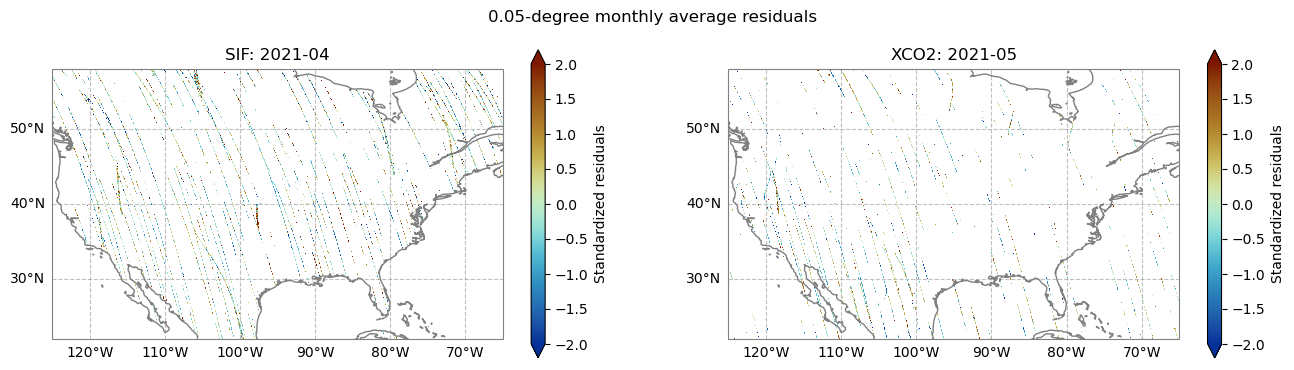

In [9]:
# modeling setup
datasets = [ds_sif, ds_xco2]
timedeltas = [0, OFFSET]

vario_config = fields.VarioConfig(MAX_DIST, N_BINS, n_procs=2)
mf = fields.MultiField(datasets, date_sif, timedeltas)
plot.plot_fields(mf, ["SIF", "XCO2"])


In [10]:
df_sif_res = mf.fields[0].to_dataframe()[["lon", "lat", "sif"]]
df_sif_res["sif"].describe()


count    3.633900e+04
mean    -1.368722e-18
std      1.000000e+00
min     -4.988969e+00
25%     -5.507953e-01
50%     -4.170282e-02
75%      4.950242e-01
max      1.212056e+01
Name: sif, dtype: float64

In [11]:
# construct the empirical (cross-) semivariograms
gamma = mf.empirical_variograms(vario_config)
gamma.df.to_csv(f"../../data/intermediate/models/{year_month_str}/variograms.csv")


In [12]:
# fit the model via multivariate WLS
bivariate_matern = model.MultivariateMatern(n_procs=2)
bivariate_matern.params.set_bounds(**PARAM_BOUNDS)
bivariate_matern.fit(gamma)
df_params = bivariate_matern.params.to_dataframe()
df_params.to_csv(f"../../data/intermediate/models/{year_month_str}/bivariate_model.csv")
df_params


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


,name,value,bounds
0,sigma_11,0.477860,"(0.4, 3.5)"
1,sigma_22,0.744112,"(0.4, 3.5)"
2,nu_11,0.950000,"(0.3, 0.95)"
3,nu_12,1.500000,"(0.5, 1.5)"
4,nu_22,0.656928,"(0.3, 0.95)"
5,len_scale_11,36.091086,"(10, 300)"
6,len_scale_12,100.006582,"(10, 300)"
7,len_scale_22,61.365327,"(10, 300)"
8,nugget_11,0.750536,"(0.0, 0.9)"
9,nugget_22,0.417493,"(0.0, 0.9)"


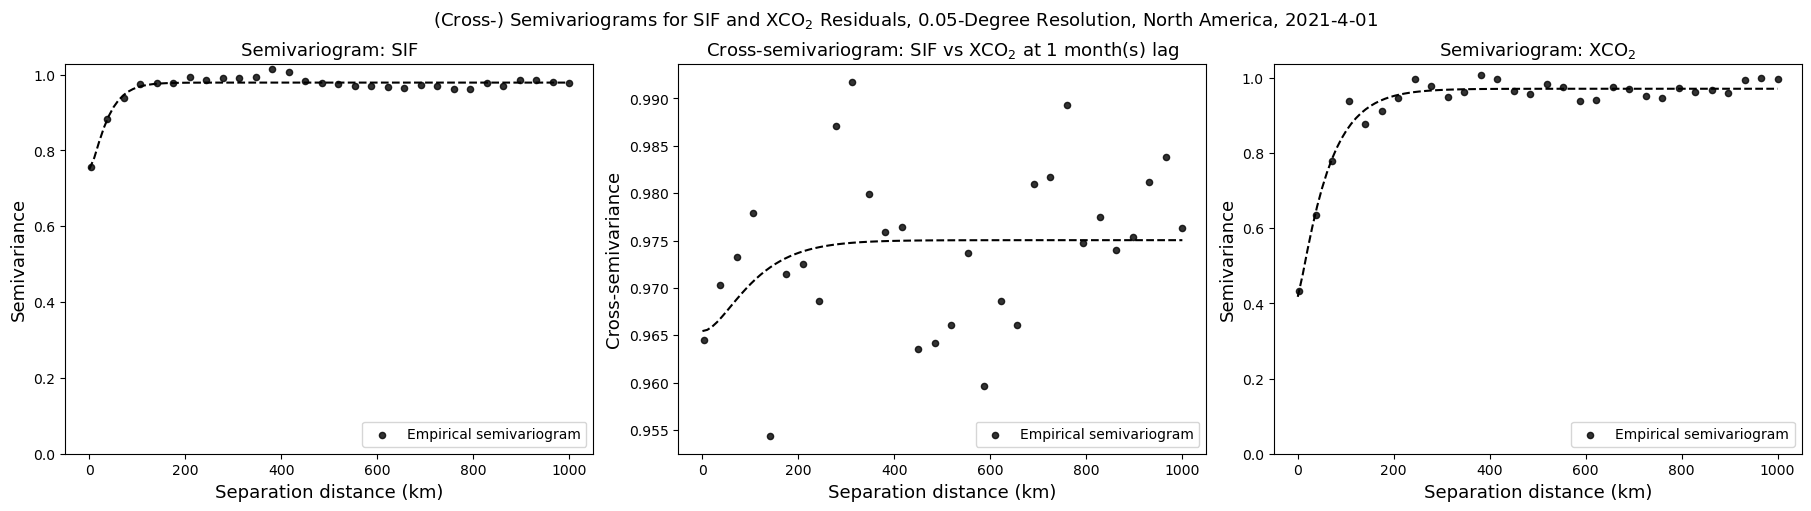

In [13]:
title = (
    f"(Cross-) Semivariograms for SIF and XCO$_2$ Residuals, 0.05-Degree Resolution, "
    f"North America, {date_sif}"
)
plot.plot_variograms(bivariate_matern.fit_result, ["SIF", "XCO$_2$"], title=title)


## Save the fields, semivariograms, and model

In [14]:
with open(f"../../data/intermediate/models/{year_month_str}/fields.pickle", "wb") as f:
    pickle.dump(mf, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"../../data/intermediate/models/{year_month_str}/variograms.pickle", "wb") as f:
    pickle.dump(gamma, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"../../data/intermediate/models/{year_month_str}/bivariate_model.pickle", "wb") as f:
    pickle.dump(bivariate_matern, f, protocol=pickle.HIGHEST_PROTOCOL)
